In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.linalg import svd, orth, qr
from scipy.optimize import curve_fit
from numpy import sin, cos, pi
cmap = plt.cm.plasma

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc, Fourier

In [3]:
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')

8.030570172000001


In [4]:
m, n = 2500, 2501
x = Domain([0, 1], m)
mu = Domain([0, 1], n)

r = min(m, n)
i = np.arange(0, r)
N = np.arange(1, r+1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


0


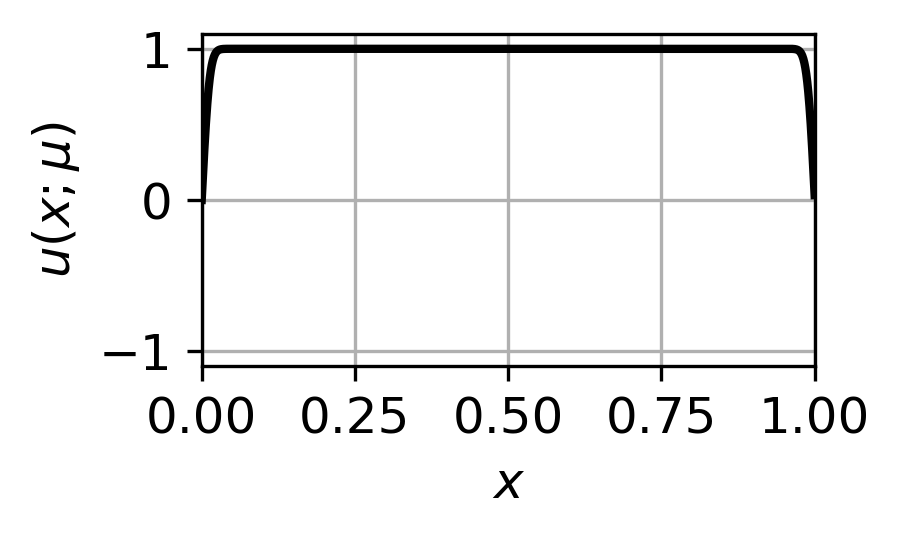

250


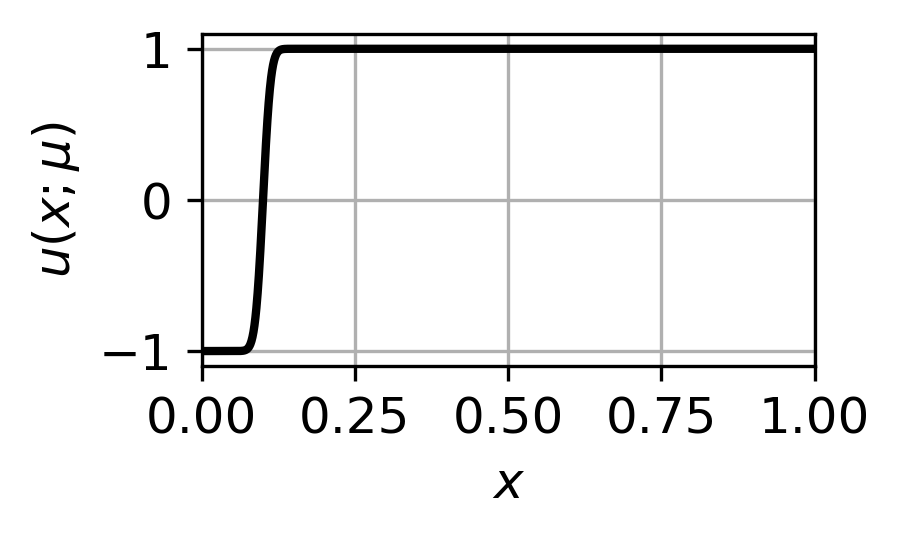

500


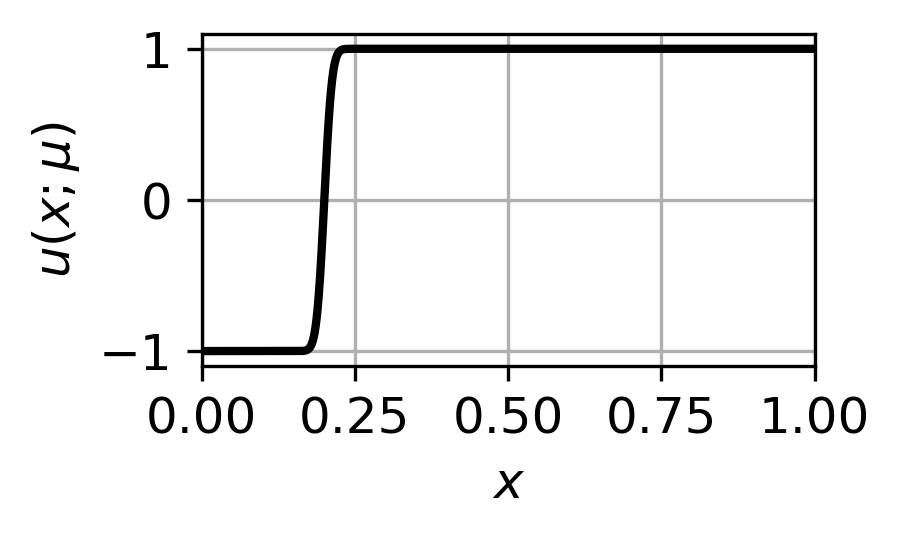

750


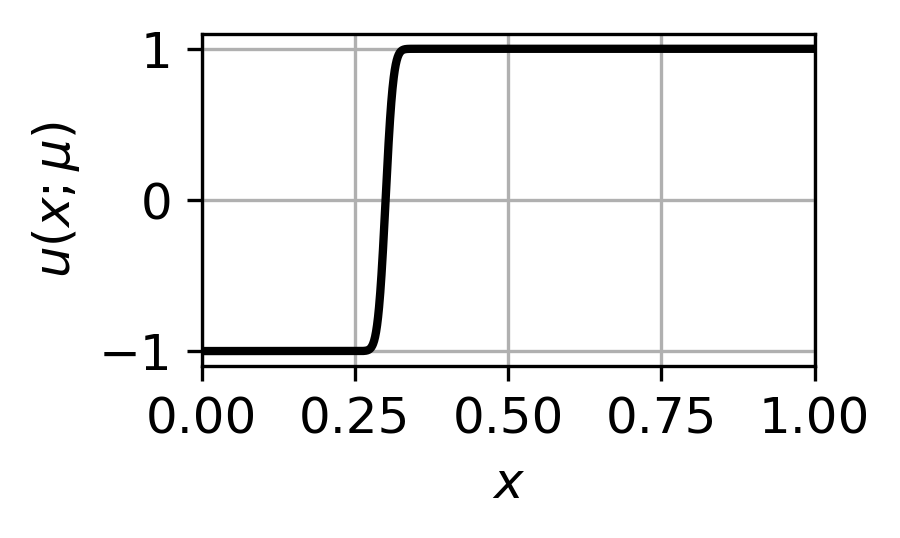

1000


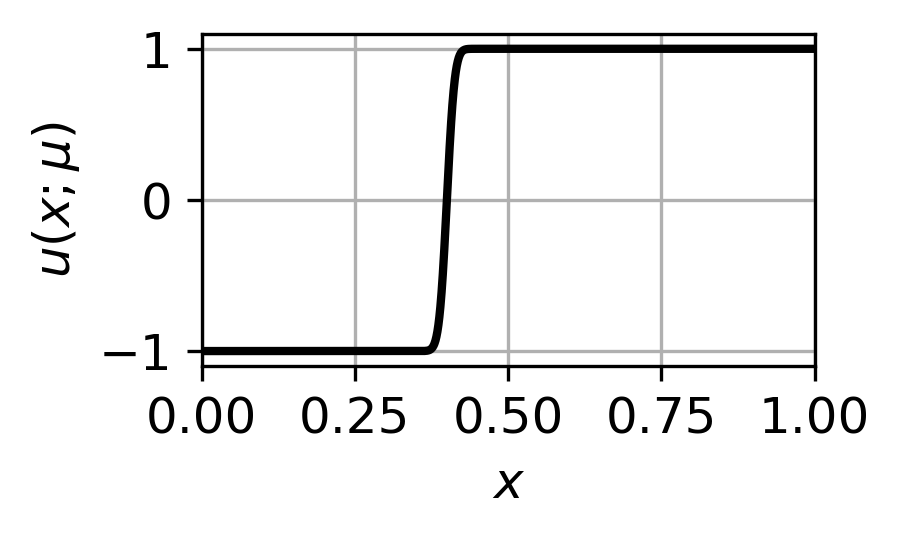

1250


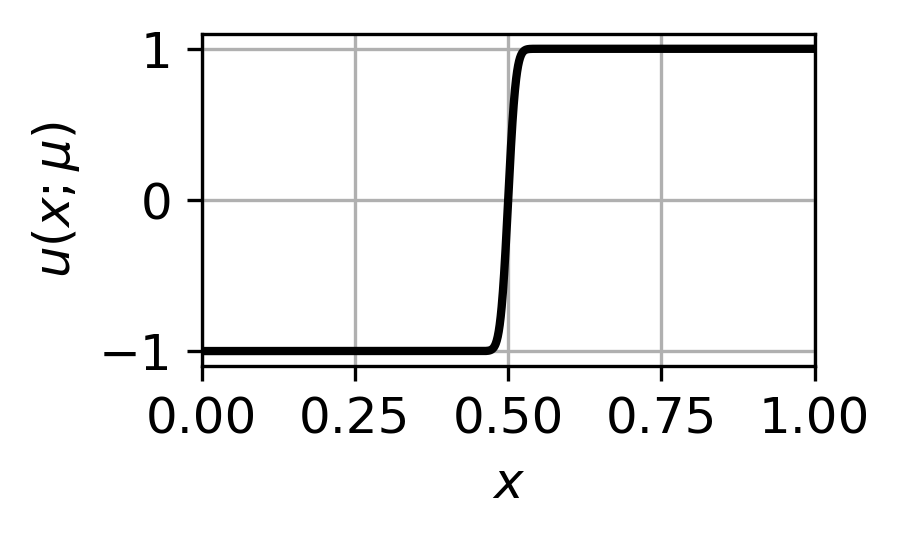

1500


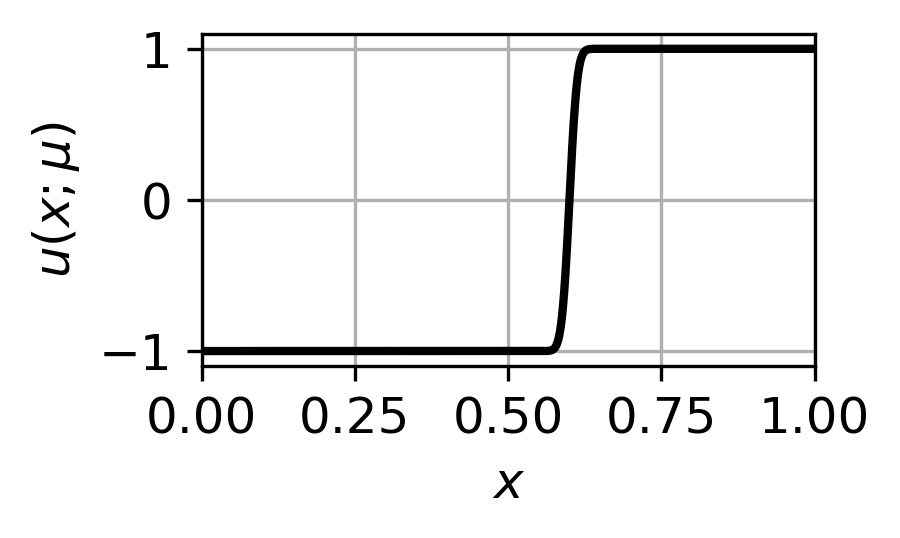

1750


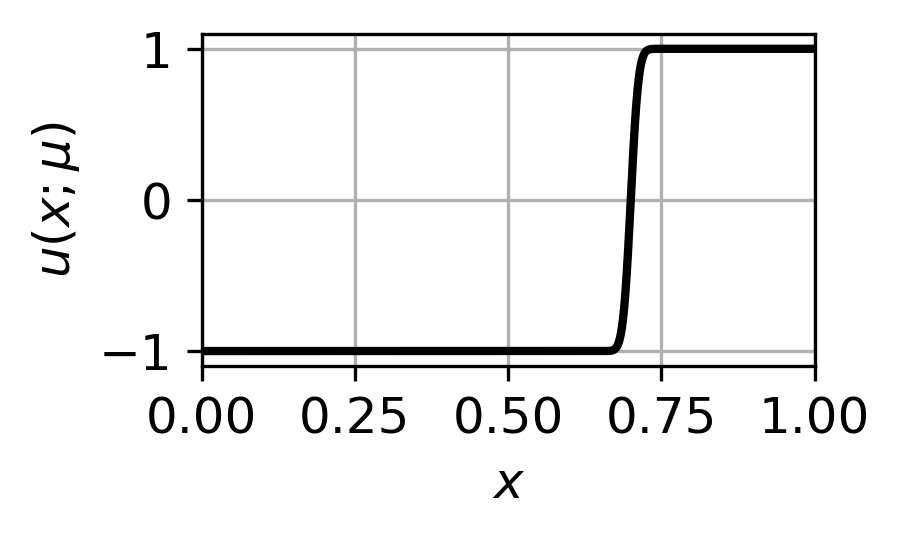

2000


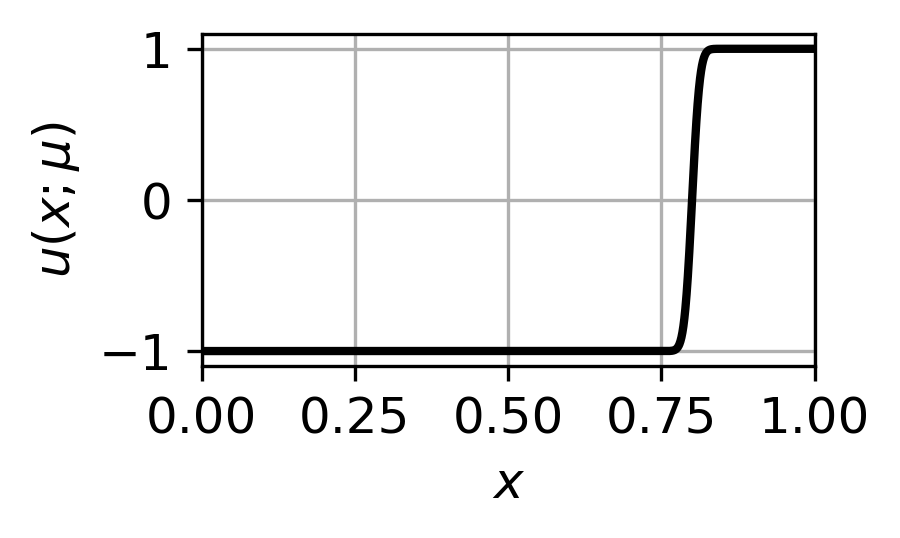

2250


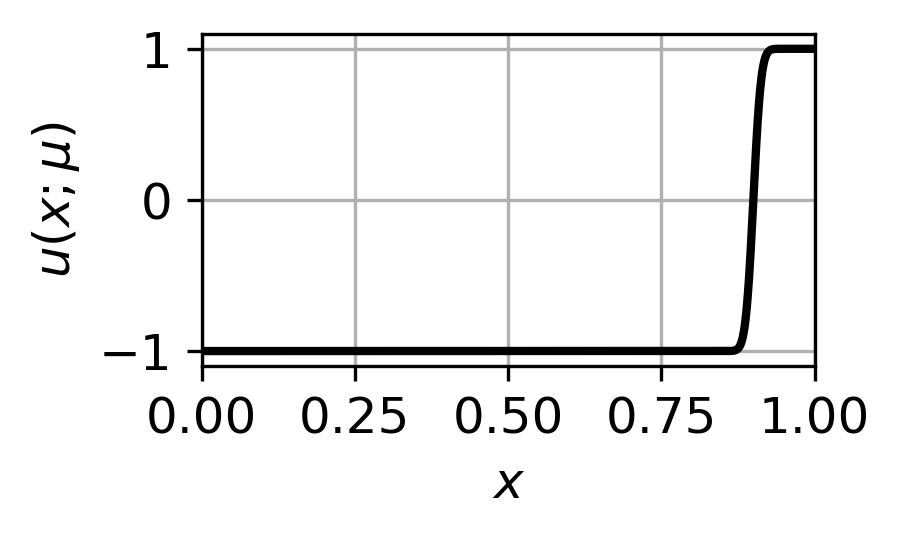

2500


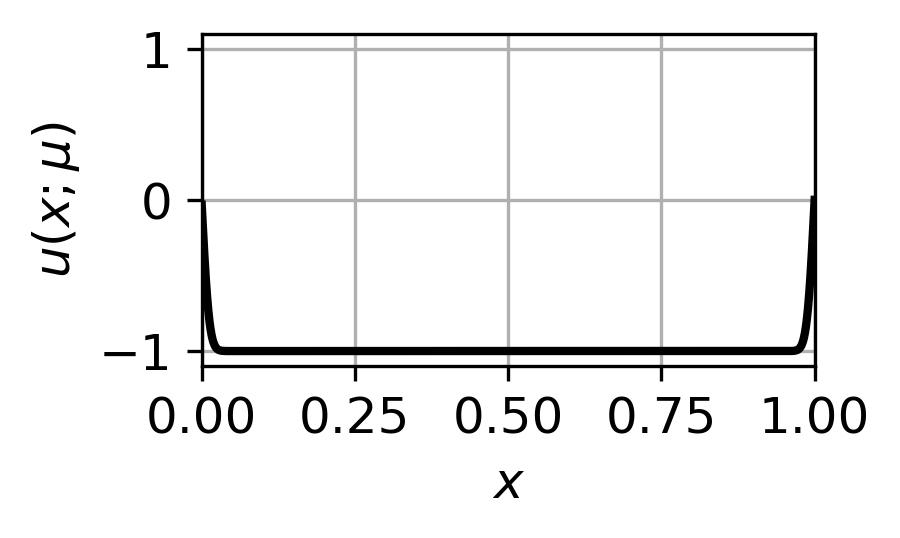

In [5]:
u_hs = Sigmoid(0.025)
X = u_hs(x(), mu())

for j in range(n):
    if j%250 == 0:
        print(j)
        fig, ax = plt.subplots(tight_layout=True)
        ax.plot(x(), X[:, j], "k-", lw=2)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$u(x; \mu)$")
        ax.set_xlim([0, 1])
        ax.set_ylim([-1.1, 1.1])
        ax.grid()
        plt.savefig("C:/Users/florianma/Dropbox/Kol-N-width-Oslo-Ulm/Plots/ani/frame_{:04d}.png".format(j))
        plt.show()

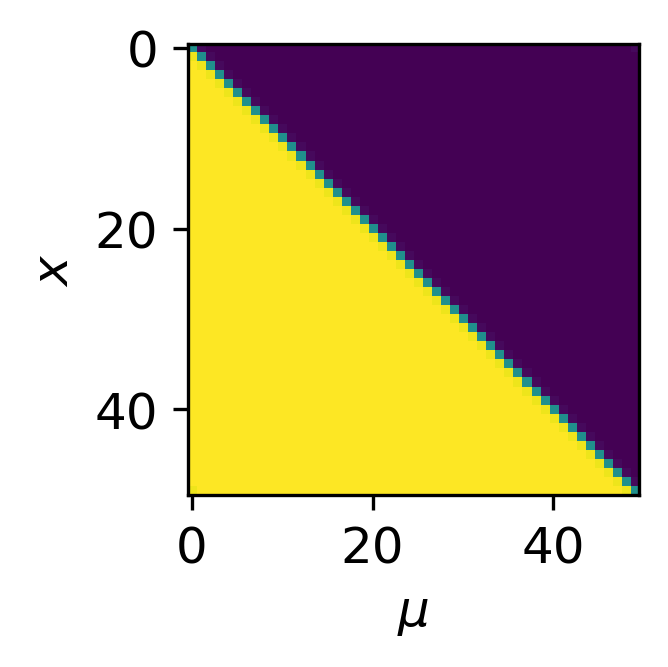

[[ 0.         -0.94799051 -0.99979257 ... -0.99999995 -0.99979257
  -0.94799051]
 [ 0.94799051  0.         -0.94799051 ... -1.         -0.99999995
  -0.99979257]
 [ 0.99979257  0.94799051  0.         ... -1.         -1.
  -0.99999995]
 ...
 [ 0.99999995  1.          1.         ...  0.         -0.94799051
  -0.99979257]
 [ 0.99979257  0.99999995  1.         ...  0.94799051  0.
  -0.94799051]
 [ 0.94799051  0.99979257  0.99999995 ...  0.99979257  0.94799051
   0.        ]]


In [9]:
m, n = 50, 50
x = Domain([0, 1], m)
mu = Domain([0, 1], n)
X = u_hs(x(), mu())

fig, ax = plt.subplots()
ax.imshow(X, interpolation="nearest")
ax.set_ylabel("$x$")
ax.set_xlabel("$\mu$")
plt.show()
print(X)

In [10]:
trig_basis_odd = TrigonometricOdd(x())
d_N, S = trig_basis_odd.calc_error_analytic(X)

(6, 1)
(6, 50)


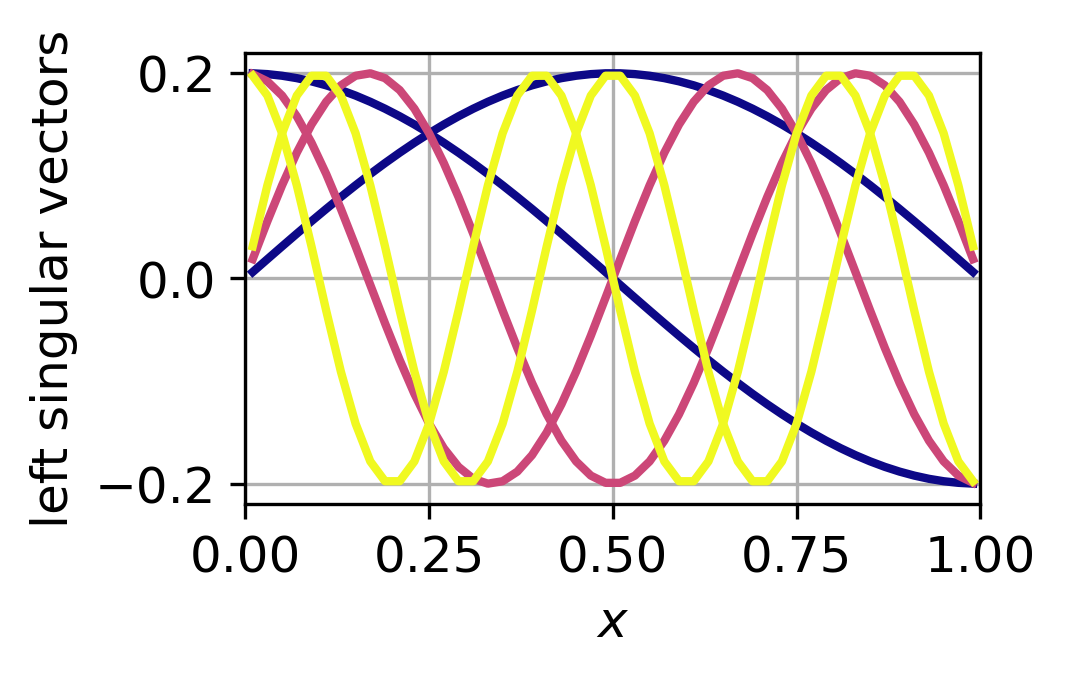

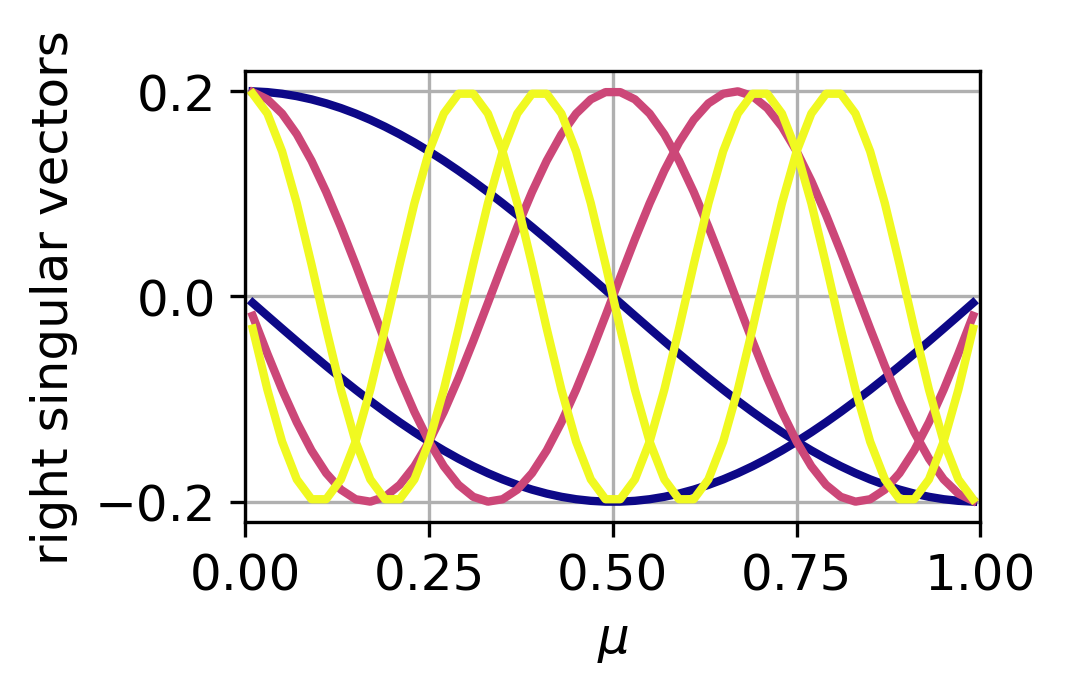

In [11]:
modes = 3
U = trig_basis_odd.U[:, :2*modes]
SVT = U.T@X
S = np.sum(SVT**2, axis=1)[:, None]**.5
VT = SVT / S

print(S.shape)
print(VT.shape)
fig, ax_l = plt.subplots()
fig, ax_r = plt.subplots()
for r in range(modes):
    phi1 = U[:, 2*r]
    phi2 = U[:, 2*r+1]
    psi1 = VT[2*r, :]
    psi2 = VT[2*r+1, :]
    
    color = cmap(r/(modes-1))
    ax_l.plot(x(), phi1, lw=2, color=color)
    ax_l.plot(x(), phi2, lw=2, color=color)
    ax_r.plot(mu(), psi1, lw=2, color=color)
    ax_r.plot(mu(), psi2, lw=2, color=color)
ax_l.set_xlabel("$x$")
ax_r.set_xlabel("$\mu$")
ax_l.set_ylabel("left singular vectors")
ax_r.set_ylabel("right singular vectors")
ax_l.set_xlim([0,1])
ax_r.set_xlim([0,1])
ax_l.grid()
ax_r.grid()
plt.show()

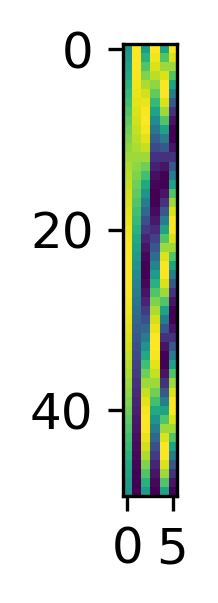

In [15]:
plt.imshow(U)

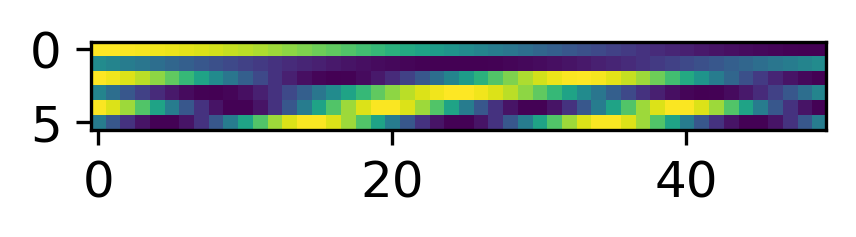

In [16]:
plt.imshow(VT)

In [ ]:
asd

In [9]:
d_N_low_res = {}
for m in np.arange(1000, 11000, 1000):
    n = m
    print(m)
    x = Domain([0, 1], m)
    mu = Domain([0, 1], n)
    X = u_hs(x(), mu())
    X[np.abs(X)<1e-6] = 1.0
    trig_basis_odd = TrigonometricOdd(x())
    d_N, S = trig_basis_odd.calc_error_analytic(X)
    d_N_low_res[m] = d_N

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [10]:
def sort_trig_basis(trig_basis_odd, X, PLOT=True):
    V_k = trig_basis_odd.U.reshape(m, -1, 2)  # x, r, 2
    V_1 = V_k[:, :, 0].copy()  # sin
    c = V_1.T @ X  # V_1.T @ X is slow!
    c_n = (c**2).sum(axis=1)
    order = np.argsort(-c_n)
    if PLOT:
        V_1 = V_k[:, :, 1].copy()  # sin
        c2 = V_1.T @ X  # V_1.T @ X is slow!
        c_n2 = (c**2).sum(axis=1)
        fig, ax = plt.subplots()
        ax.plot(trig_basis_odd.frequencies, c_n**.5, ".", ms=1)
        ax.plot(trig_basis_odd.frequencies, c_n2**.5, ".", ms=1)
        ax.set_yscale('log')
        plt.show()
    trig_basis_odd.U = V_k[:, order, :].reshape(m, -1)
    trig_basis_odd.frequencies = trig_basis_odd.frequencies[order]
    return None

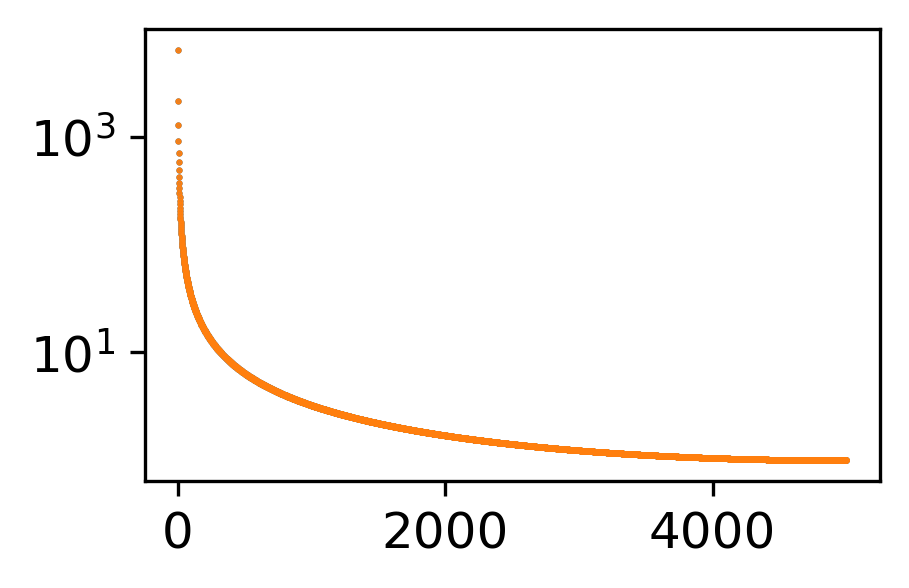

In [11]:
sort_trig_basis(trig_basis_odd, X)

In [12]:
lbl1 = r'$2*\sqrt {\left( \frac{2}{N \pi^2} \right)}$'
lbl2 =  r'$2 \sqrt {\left( \frac{1}{2} - \frac{4}{\pi^2} \sum_{i=1}^N  \frac{1}{(2i-1)^2 } \right)}$'
lbl3 =  r'$\sqrt {\left(  \sum_{k=N+1}^\infty  \frac{8}{(2k-1)^2 \pi^2} \right)}$'

lbl_new =  r'$\sqrt{\left(  \frac{4}{\pi^2}  \sum_{k=N+1}^\infty \left(2 \lfloor \frac{k+1}{2} \rfloor - 1 \right)^{-2}\right)}$'
decay_exact_old = 2*(1/2 - 4/np.pi**2*np.cumsum(1/(2*N-1)**2))**.5
decay_estimate = (2/(N*np.pi**2))**.5


#kp1 = np.floor((np.arange(500000000)+1)/2, dtype=np.float64)  # higher prcision is important here
floor_kp1 = (2*np.floor((np.arange(500000000)+1)/2, dtype=np.float64)-1)
d_N_exact = (4/np.pi**2 * np.cumsum((floor_kp1**-2)[::-1])[::-1][:r])**.5

#print(d_N_e1/d_N_e2)


t = 8/ ((2*k-1)**2*np.pi**2 )
res = np.cumsum(t[::-1])[::-1]
decay_new = res[i]**.5

fig, ax = plt.subplots()
#ax.plot(N, d_N, "b.", ms=1, label="POD-ROM")
i = 9
for key, val in d_N_low_res.items():
    print(key)
    color = cmap(i/8)
    i -= 1
    Nn = np.arange(1, key+1)
    d_N = val
    print(N.shape)
    print(d_N.shape)
    if key in [1000, 10000]:
        lbl = "POD-ROM (a={:.0f})".format(key)
    else:
        lbl = None
    ax.plot(Nn, d_N, "b.", label=lbl, ms=1, color=color)

#ax.plot(Nn, d_N, "b.", ms=1, label="POD-ROM (a={:.0f})".format(key), color=color)
ax.plot(N, d_N_exact, "c--", label=lbl_new, lw=1)
#ax.plot(N, decay_exact_old, "r--", label=lbl2, lw=1)
#ax.plot(i, decay_estimate, "g--", label=lbl1, lw=1)
#ax.plot(N, decay_new, "b--", label=lbl3, lw=1)
ax.plot(N, N**-.5, "k--", label=r'$N^{-1/2}$', lw=1) # too high?
#ax.plot(N, 1/2*N**-.5, "c--", label=r'$\frac{1}{2}N^{-1/2}$', lw=1)


ax.set_yscale('log')
plt.legend(prop={'size': 6})
plt.xlabel(r'$N$')
plt.ylabel(r'$\int || u_j - \tilde{u}_j ||_{L_2} d\mu$')
ax.set_xlim([0, 5000])
ax.set_ylim([1e-3, 2])
plt.grid()
plt.show()

NameError: name 'k' is not defined

In [ ]:
plt.plot(N**-.5/d_N_exact, "b.", ms=1, label=r'$N^{-1/2}/$'+lbl_new)
#plt.plot(N**-.5/decay_exact_old, "g.", ms=1, label=r'$N^{-1/2}/$'+lbl2)
plt.plot(N, N*0+np.pi/2, "r--", ms=1, label=r'$\frac{\pi}{2}$')
#plt.xlim([0, 100])
plt.ylim([np.pi/2 * .99, np.pi/2 * 1.01])
plt.legend(prop={'size': 6})
plt.xlabel(r'$N$')
plt.ylabel(r'$C$')
plt.xlim([0, r])
plt.grid()
plt.show()
print((N**-.5/decay_exact_old)[100:].mean())
print(np.pi/2)

In [ ]:
asd

In [ ]:
svd_basis = SVD(X)
results = np.zeros((3, 2, r))
for i, basis in enumerate([trig_basis_odd, svd_basis]):
    delta_n, d_n = basis.calc_error(X, r)
    results[0, i, :] = delta_n
    results[1, i, :] = d_n
    results[2, i, :] = basis.calc_error_analytic(X)[:r]

In [ ]:
fig, ax = plt.subplots()
for i, basis in enumerate([trig_basis_odd, svd_basis]):
    ax.plot(results[0, i, :], "b.", ms=1, label=basis.name)
    ax.plot(results[1, i, :], "y.", ms=1, label=basis.name)
    ax.plot(results[2, i, :], "k--", label=basis.name)
ax.set_yscale('log')
plt.legend(prop={'size': 8})
plt.show()